In [33]:
from puff_model_optimized import puff_model
import torch
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline 
from unit_conversion import convert_wind
from puff_inverse_model_optimized import puff_inverse_model
import time

In [34]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)

#### Test Case 1: downward wind, two sources and one active - sensors below. Data is noisy-ish, bc i'm eyeballing sensor vals

In [35]:
data_dir = f"{os.getcwd()}/data"
# load in data
df_wind_ch4 = pd.read_csv(data_dir + "/wind_ch4.csv")

df_true_emission = pd.read_csv(data_dir + "/selected_controll_release.csv")
source_points = np.load(data_dir + "/source_points.npy") # shape=(n_source, 3)
sensor_points = np.load(data_dir + "/sensor_points.npy") # shape=(n_sensor, 3)
#col_points = np.load(data_dir + "/col_points.npy")  # shape=(n_col, 3)
df_bounds = pd.read_csv(data_dir + "/bounds.csv", dtype='float32')
df_puff_simulation = pd.read_csv(data_dir + '/df_obs_20220502008_0.csv').fillna(0.)
# df_puff_simulation = pd.read_csv(data_dir + '/df_sim_puff_20220502008_0.csv').fillna(0.)

tfinal = 5*60.
source_location = torch.tensor(source_points)

ws = df_wind_ch4['wind_speed.m/s'].to_numpy() # shape=(N_t,)
wd = df_wind_ch4['wind_direction'].to_numpy() # shape=(N_t,)
df_puff_simulation['x'], df_puff_simulation['y'] = convert_wind(ws,wd)


wind_function_x = lambda t : torch.tensor(CubicSpline(df_puff_simulation.index*60,df_puff_simulation.x)(t))
wind_function_y = lambda t : torch.tensor(CubicSpline(df_puff_simulation.index*60,df_puff_simulation.y)(t))

# sensor_names = ['N','W','SW','S','SE','E','NE','C1','NW']
sensor_names = ['N','E','SE','S','SW','W','NW','C1','NE']
sensor_names = ['N','E','SE','S','SW','W','NW','C1','NE']
filter_out = ['C1']
df_sensor = pd.DataFrame(sensor_points,columns = ['x','y','z'])
df_sensor['name'] = sensor_names
df_sensor['filter'] = df_sensor.name.apply(lambda x : int(x in filter_out))
sensor_points_filtered = (df_sensor[df_sensor['filter'] != 1][['x','y','z']]).to_numpy()
sensor_locations = df_sensor[['x','y','z']].to_numpy()


sensor_names  =  list(filter(lambda x : x not in filter_out, sensor_names))
print(sensor_names)
print('hello')
num_sensors = len(sensor_names)



sensor_values_fn = dict()
for name in sensor_names:
    if name in filter_out:
        pass
    sensor_values_fn[name] = lambda t, f = CubicSpline(df_puff_simulation.index*60,df_puff_simulation[name]) : torch.tensor(f(t))
# ch4 = np.transpose(df_wind_ch4.iloc[:, 3:].to_numpy()) # shape=(N_obs, N_t)
# sensor_names = df_wind_ch4.columns[3:]


['N', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'NE']
hello


#### Create observation data matrix of 100 obs across domain of 45 min


In [36]:
num_obs = 300
tbegin = 0*60
tend = 45*60
obs_t = torch.linspace(tbegin,tend,num_obs).reshape(-1,1)
obs = torch.zeros(num_obs, num_sensors)
obs += torch.rand(obs.shape)*0
for i in range(num_obs):
    for j in range(num_sensors):
        obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i].item()))
obs = obs.T.reshape(-1,1)
obs_x = torch.tile(torch.tensor(sensor_points_filtered).reshape(-1,1,3),(1,obs_t.shape[0],1)).reshape(-1,3)
obs_t = obs_t.repeat(num_sensors,1)


C:\Users\m10936927\AppData\Local\Temp\ipykernel_22380\2109605859.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i].item()))


In [37]:
num_t = 50
num_xy = 50
pm = puff_model(source_location, sensor_points_filtered, [3, 3, 1], wind_function_x, wind_function_y,[1,1],3,spread=True,t_max=45*60)
Q = pm.return_puff_matrix(obs_x,obs_t)
weights = torch.diag(torch.sum(Q,dim=1))
pim = puff_inverse_model(pm)
x = pim.solve_inverse_problem(obs_x, obs_t, obs, num_nz = 1, bias_terms = 1, weights=None)
# print(x)
X,Y,Z = torch.meshgrid(torch.linspace(0,130,num_xy),torch.linspace(0,80,num_xy),torch.tensor([2.4]),indexing='xy')
XX = torch.cat([X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1)],dim=1).repeat(num_t,1)
# x = pim.solve_inverse_problem_base(obs, obs_t, num_nz = 1, weights = None)
t = torch.linspace(0,45*60,num_t).reshape(-1,1).repeat(1,num_xy**2).reshape(-1,1)
result = pm.simulate_concentration(XX,t)

In [38]:
1//.5

2.0

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize


# def plot_colored_arrows(wd, ws, origin_x=0, origin_y=0, color_by='index'):
#     wd = np.array(wd)
#     ws = np.array(ws)
#     n = len(wd)
#     assert wd.shape == ws.shape, "Angle and magnitude arrays must match"

#     # Compute vector components
#     theta = np.deg2rad(wd)
#     u = ws * np.cos(theta)
#     v = ws * np.sin(theta)

#     # Starting positions
#     x0 = np.full_like(u, origin_x)
#     y0 = np.full_like(v, origin_y)

#     # Values to color by (either index or magnitude)
#     if color_by == 'index':
#         color_values = np.linspace(0, 1, n)
#         label = "Arrow Index"
#     elif color_by == 'magnitude':
#         color_values = (ws - ws.min()) / (ws.max() - ws.min() + 1e-8)
#         label = "Magnitude"
#     else:
#         raise ValueError("color_by must be 'index' or 'magnitude'")

#     cmap = get_cmap('coolwarm')  # red to blue
#     norm = Normalize(vmin=0, vmax=1)

#     # Create quiver plot
#     fig, ax = plt.subplots(figsize=(8, 8))
#     q = ax.quiver(x0, y0, u, v, color_values, cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1)

#     # Add colorbar
#     cbar = fig.colorbar(q, ax=ax)
#     cbar.set_label(label)

#     ax.set_aspect('equal')
#     ax.set_title("Colored Arrows with Colorbar")
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")
#     ax.grid(True)

# plot_colored_arrows(wd, ws)
# plt.xlim(-3,3)
# plt.ylim(-3,3)

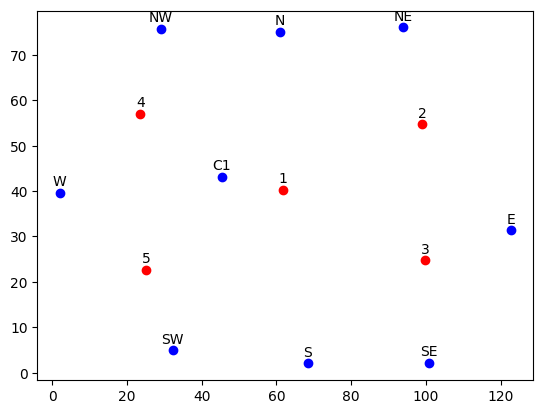

In [40]:
fig,ax = plt.subplots()
ax.scatter(source_location[:,0],source_location[:,1],color='red')
ax.scatter(sensor_points[:,0],sensor_points[:,1],color='blue')

labels = df_sensor['name']
for i, label in enumerate(labels):
    plt.annotate(label, (df_sensor.x[i], df_sensor.y[i]), textcoords="offset points", xytext=(0,5), ha='center')
for i in range(len(source_location)):
    plt.annotate(str(i+1), (source_location[i,0],source_location[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

In [41]:
print(sensor_values_fn['NW'](16))

tensor(2.0335, dtype=torch.float64)


In [42]:
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = interp1d(df_puff_simulation.index*60,df_puff_simulation[name])

sensor_values_fn_1 = dict()
for name in sensor_names:
    sensor_values_fn_1[name] = lambda t, x = sensor_values_fn[name] : torch.tensor(x(t))


In [43]:
# result = result.reshape(-1,t.shape[0]).T.reshape(-1,1)
# result = result.reshape(X.shape)

In [44]:
print(XX.shape[0])
print(result.shape[0])

125000
125000


tensor(2.0255)


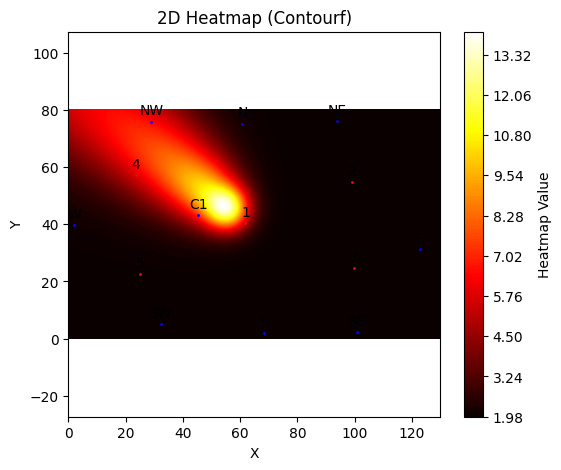

In [45]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
print(torch.min(result))
# Convert to NumPy
t_step=num_t-2
x = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),0].squeeze().numpy()
y = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),1].squeeze().numpy()
z = result[result.shape[0]//num_t*t_step:result.shape[0]//num_t*(t_step+1)].squeeze().numpy()
# Create grid
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 200),
    np.linspace(y.min(), y.max(), 200)
)

# Interpolate to the grid
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Plot with contourf
plt.figure(figsize=(6, 5))
# cont = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='hot')
cont = plt.contourf(grid_x, grid_y, grid_z, levels=200, cmap='hot')

plt.scatter(source_location[:,0],source_location[:,1],color='red',s=1)
plt.scatter(sensor_points[:,0],sensor_points[:,1],color='blue',s=1)

labels = df_sensor['name']
for i, label in enumerate(labels):
    plt.annotate(label, (df_sensor.x[i], df_sensor.y[i]), textcoords="offset points", xytext=(0,5), ha='center')
for i in range(len(source_location)):
    plt.annotate(str(i+1), (source_location[i,0],source_location[i,1]), textcoords="offset points", xytext=(0,5), ha='center')
plt.colorbar(cont, label="Heatmap Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Heatmap (Contourf)")
plt.axis("equal")
plt.show()


In [46]:
import imageio
filename = 'output'
os.makedirs("frames", exist_ok=True)

filenames = []
for t_step in range(num_t):
    x = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),0].numpy()
    y = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),1].numpy()


    z = result[result.shape[0]//num_t*t_step:result.shape[0]//num_t*(t_step+1)].squeeze().numpy()
    # z = result[XX.shape[0]*t_step : XX.shape[0]*(t_step+1)].squeeze().numpy()

    # Create grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 200),
        np.linspace(y.min(), y.max(), 200)
    )

    # Interpolate
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cont = ax.contourf(grid_x, grid_y, grid_z, levels=100, cmap='hot')

    ax.scatter(source_location[:,0], source_location[:,1], color='red', s=1)
    ax.scatter(sensor_points[:,0], sensor_points[:,1], color='blue', s=1)

    labels = df_sensor['name']
    for i, label in enumerate(labels):
        ax.annotate(label, (df_sensor.x[i], df_sensor.y[i]), textcoords="offset points", xytext=(0,5), ha='center')

    for i in range(len(source_location)):
        ax.annotate(str(i+1), (source_location[i,0], source_location[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

    fig.colorbar(cont, ax=ax, label="Heatmap Value")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    # print(t[t_step])
    ax.set_title(f"2D Heatmap at t={t[t_step]}")
    ax.axis("equal")

    # Save frame
    filename = f"frames/frame_{t_step:03d}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create GIF
with imageio.get_writer('heatmap_animation.gif', mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally clean up
for filename in filenames:
    os.remove(filename)

C:\Users\m10936927\AppData\Local\Temp\ipykernel_22380\3655555744.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [47]:
z = result[result.shape[0]//num_t*t_step:result.shape[0]//num_t*(t_step+1)].squeeze().numpy()


8


C:\Users\m10936927\AppData\Local\Temp\ipykernel_22380\977675595.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


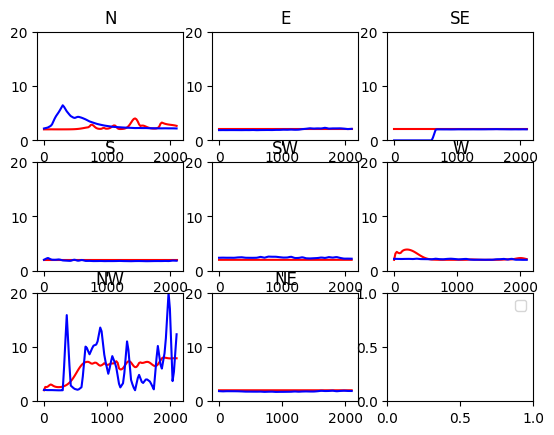

In [48]:
fig, ax  = plt.subplots(3,3)
obs_t = torch.linspace(0,35*60,100).reshape(-1,1)
t = obs_t
num_obs = obs_t.shape[0]
obs_x = torch.tile(torch.tensor(sensor_points_filtered).reshape(-1,1,3),(1,obs_t.shape[0],1)).reshape(-1,3)
obs_t = obs_t.repeat(num_sensors,1)
print(num_sensors)

result_final = pm.simulate_concentration(obs_x,obs_t)
M_torch = pim.Q
for i in range(num_sensors):
    ax[i//3,i%3].set_title(sensor_names[i])
    tt = obs_t
    ax[i//3,i%3].plot(t,(result_final[num_obs*i:(num_obs*(i+1)),:]).view(-1) ,color='red',label='predicted')
    ax[i//3,i%3].plot(t,sensor_values_fn[sensor_names[i]](t),color='blue',label='true')
    ax[i//3,i%3].set_ylim(0,20)
    plt.legend()
    